# MU 5 domaci zadatak
**student**: Veljko Milojevic

**broj indeksa**: 3066/2023

In [1]:
import numpy as np
import string
import IPython.display
import time 

In [2]:
FIGSIZE = (12, 6)
DPI = 100
ALPHA = 0.4

Treba da implementirate:
1) simulator,
2) algoritam Q-ucenja,
3) algoritam REINFORCE,
za jednostavno okruzenje, prema uputstvima datim u nastavku.

## Okruzenje

Agent zivi u jednostavnom okruzenju prikazanom na slici.


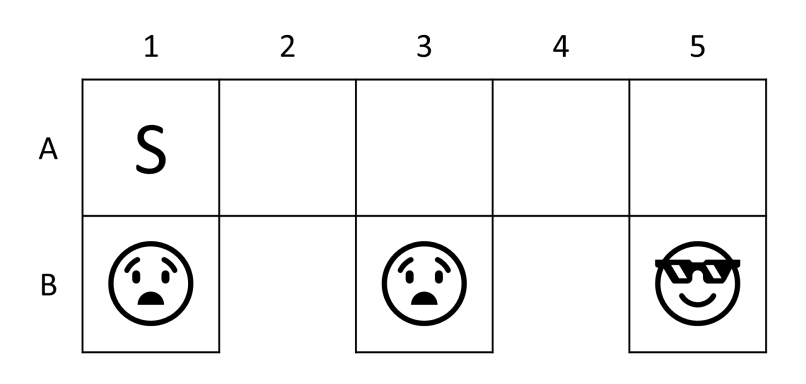

Pocetno stanje je A1 (oznaceno sa S na slici). Stanja B1, B3 i B5 su terminalna; kada se agent nade u bilo kom od njih, kakvu god akciju da preduzme, dobija nagradu −1 (u stanjima B1 i B3) ili +3 (u stanju B5), nakon cega se epizoda zavrsava i agent se vraca u pocetno stanje. U svim ostalim slucajevima, agent ne dobija nikakvu nagradu. Smatrajte da je okruzenje potpuno opservabilno i da agent uvek zna u kom stanju se nalazi. 

U svakom od 8 stanja agent ima na raspolaganju 4 akcije: gore, dole, levo, desno. Okruzenje je stohasticno, u sledecem smislu: kada agent odabere akciju, pomera se u izabranom smeru (pomera se u polje levo, desno, iznad ili ispod trenutnog) sa verovatnocom 0.6; u protivnom se pomera u nekom od 2 smera koja leze pod pravim uglom u odnosu na izabrani, sa podjednakim verovatnocama. Ukoliko udari u zid, ostaje u istom stanju. Na primer, ako izabere akciju “desno” u pocetnom stanju, sa verovatnocom 0.6 prelazi u polje A2, sa verovatnocom 0.2 udara u gornji zid i ostaje u polju A1 i sa verovatnocom 0.2 prelazi u polje B1.

## Simulator
Okruzenju se zadaje akcija na osnovu koje on azurira interno stanje (u skladu sa prethodnim opisom), i vraca:

* osvojenu nagradu u tom koraku,
* novo stanje,
* informaciju o tome da li je epizoda zavrsena.


In [3]:
class Simulator:
    def __init__(self, grid, action_set):
        self.__action_set = action_set
        self.__grid = grid
        self.__real_action = ""
        self.__finished = False
        self.__state_value = 0
        self.__state = np.ravel(np.array(np.where(self.__grid=='S')))
        self.__heigth, self.__width = self.__grid.shape
        self.__iteration = 0
        return
    
    def decode_state(self, state):
        return string.ascii_uppercase[state[0]] + str(state[1]+1)
    
    def get_grid(self):
        return self.__grid
    
    def get_start_state(self):
        return self.decode_state(np.ravel(np.array(np.where(self.__grid=='S'))))
    
    def get_action_set(self):
        return self.__action_set
    
    def increment_state(self, action):
        if not self.__finished:
            t = np.random.rand()
            if t <= 0.6:
                self.__real_action = action
             
            # slipping 
            if t > 0.6 and t <= 0.8 :
                if action == "up" or action == "down":
                    self.__real_action = "left"
                if action == "left" or action == "right":
                    self.__real_action = "up"
            
            if t>0.8:
                if action == "up" or action == "down":
                    self.__real_action = "right"
                if action == "left" or action == "right":
                    self.__real_action = "down"
            
            # print(self.__real_action)
            self.__action = np.array(self.__action_set[self.__real_action])
            temp = self.__state + self.__action
            
            if not(temp[0] == self.__heigth or temp[1] == self.__width or
                   temp[0] < 0 or temp[1] < 0 or
                   self.__grid[temp[0], temp[1]] == 'x'):
                self.__state += self.__action
            
            self.__get_state_value()
            self.__iteration += 1
            return self.decode_state(self.__state), self.__state_value, self.__finished
        
        else:
            print("Reset simulator! ")
            return None
    
    def __get_state_value(self):
        if (self.__grid[self.__state[0], self.__state[1]] == 'S' or
            self.__grid[self.__state[0], self.__state[1]] == ''):
            self.__state_value = 0
        else:
            self.__finished = True
            self.__state_value = self.__grid[self.__state[0], self.__state[1]]
            
    def reset(self):
        self.__real_action = ""
        self.__finished = False
        self.__state_value = 0
        self.__iteration = 0
        self.__state = np.ravel(np.array(np.where(self.__grid=='S')))
        
    def render(self):
        print("  |-1-|-2-|-3-|-4-|-5-|")
        for i in range(self.__grid.shape[0]):
            s = string.ascii_uppercase[i] + " |"
            for j in range(self.__grid.shape[-1]):
                if self.__grid[i, j] == 'x':
                    s += "x"
                else:
                    s += " "
                if self.__state[0] == i and self.__state[1]==j:
                    s += "*"
                else:
                    s += " "
                s += " |"
            print(s)
        print("State value: ", self.__state_value)
        print("Real action: ", self.__real_action)
        print("Iteration: ", self.__iteration)
        return

In [4]:
def make_grid():
    # S - starting field
    # x - illegal field
    # integer value - terminal field value
    grid = [['S', '', '', '', ''],
            [-1, 'x', -1, 'x', 3]]
    return np.array(grid)

In [5]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
simulator = Simulator(grid, action_set)

actions_set = np.array(["up", "down", "left", "right"])
i = 0
while i<10:
    IPython.display.clear_output(wait=True)
    print("Epoch: ", i)
    a = np.random.choice(actions_set)
    new_state, value, finished = simulator.increment_state(a)
    simulator.render()
    if finished:
        simulator.reset()
        i += 1

Epoch:  9
  |-1-|-2-|-3-|-4-|-5-|
A |   |   |   |   |   |
B | * |x  |   |x  |   |
State value:  -1
Real action:  down
Iteration:  1


## Q-ucenje
Faktor umanjenja buducih nagrada je $\gamma = 0.9$, ako drugacije nije receno. Koristite $\epsilon$-gramzivo istrazivanje. Adekvatnu vrednost za ϵ odredite kroz eksperimente. Teorijski, stopa ucenja bi trebalo da se smanjuje tokom vremena, ali ne prebrzo. Isprobajte strategiju koja uzima $\alpha_e = \frac{ln(e+1)}{e+1}$, gde je $e$ redni broj epizode. U praksi se cesto usvaja i konstantna stopa ucenja (ista u svim epizodama). Kroz eksperimente probajte da pronadete neku adekvatnu vrednost za konstantnu stopu ucenja, pa uporedite brzinu konvergencije sa prethodnim slucajem kada je stopa promenljiva.

Da biste pratili kako ucenje napreduje i da li je konvergiralo, prikazite kako se sa iteracijama t menjaju V-vrednosti $V_t(s) = max_a Q_t(s, a)$. Testirajte konacnu naucenu politiku kroz 10 epizoda interakcije sa okruzenjem i izracunajte prosecnu ukupnu nagradu koju agent osvaja tokom jedne epizode prateci ovu politiku. Zatim ponovite ovo za $\gamma = 0.999$. Ima li razlika u odnosu na slucaj sa $\gamma = 0.9$? Kako ih tumacite?


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
class Q_learning:
    def __init__(self, simulator: Simulator, gamma, alpha, epsilon, epochs):
        self.__simulator = simulator
        self.__gamma = gamma
        
        self.__epochs = epochs
        self.__eps = epsilon
        self.__alpha = alpha
        self.__q_values_table = self.__make_q_values_table()
        self.__policy_table = self.__make_policy_table()
        return
    
    def __label_states(self):
        grid = self.__simulator.get_grid()
        heigth, width = grid.shape
        self.__states = []
        for i in range(heigth):
            for j in range(width):
                if grid[i, j] != 'x':
                    self.__states.append(string.ascii_uppercase[i] + str(j+1))
                    
        return 
    
    def __make_q_values_table(self):
        self.__label_states()
        data = {"up": 0, "down": 0, "left": 0, "right": 0, "max": 0}         
        return pd.DataFrame(data, index=self.__states)
    
    def __make_policy_table(self):
        grid = self.__simulator.get_grid()
        action_set = list(self.__simulator.get_action_set().keys())
        heigth, width = grid.shape
        data = []
        for i in range(heigth):
            for j in range(width):
                if grid[i, j] != 'x':
                    action = np.random.choice(action_set)
                    data.append({"action": action})
                    
        return pd.DataFrame(data, index=self.__states)
        

    def fit(self, verbose: bool):
        action_set = list(self.__simulator.get_action_set().keys())
        epp = 0
        self.__simulator.reset()
        state = self.__simulator.get_start_state()
        self.__v_values = np.empty(shape=(self.__epochs, len(self.__states)))
        self.__mean_values = []
        
        while epp < self.__epochs:
            # eps gready approach
            temp = np.random.rand()
            if type(self.__eps) == float:
                eps = self.__eps
            else:
                eps = self.__eps[epp]
            
            if temp < eps:
                action = np.random.choice(action_set)
            else:
                action = self.__policy_table.loc[state].iloc[0]
            
            new_state, value, finished = self.__simulator.increment_state(action)
            v_value = self.__q_values_table.loc[new_state, 'max']
            
            q = float(value) + self.__gamma*v_value 
            
            # updating Q(s, a) <- Q(s, a) + alpha*(q(s,a) - Q(s, a))
            if type(self.__alpha) == float:
                alpha = self.__alpha
            else:
                alpha = self.__alpha[epp]
            Q = self.__q_values_table.loc[state, action]
            self.__q_values_table.loc[state, action] = Q + alpha*(q - Q)
            
            # updating V value
            self.__q_values_table.loc[state, 'max'] = self.__q_values_table.loc[state, action_set].max()
            
            # upadating policy
            best_action = self.__q_values_table.loc[state, action_set].idxmax()
            self.__policy_table.loc[state, "action"] = best_action
            
            if not finished:
                state = new_state
            # time.sleep(.3)
            if finished:
                if verbose:                    
                    if epp % 10 == 0:
                        no = 10
                        values = np.empty(shape=(no))
                        for i in range(no):
                            values[i] = self.interact()
                        self.__mean_values.append(np.mean(values))
                        
                self.__v_values[epp, :] = self.__q_values_table.loc[self.__states, 'max'].to_numpy()
                state = self.__simulator.get_start_state() 
                self.__simulator.reset()
                
                epp += 1
                
                IPython.display.clear_output(wait=True)
                print("Epoch: ", epp)
                print(self.__q_values_table)
                print(self.__policy_table)
        
        if verbose:
            self.__plot()
        return
    
    def interact(self):
        self.__simulator.reset()
        state = self.__simulator.get_start_state()
        finished = False
        while not finished:
            action = self.__policy_table.loc[state].iloc[0]
            state, value, finished = self.__simulator.increment_state(action)
        self.__simulator.reset()
        return value
    
    def __plot(self):
        plt.close('all')
        plt.figure(figsize=FIGSIZE, dpi=DPI)
        plt.subplot(211)
        plt.plot(np.arange(self.__epochs) + 1, self.__eps)
        plt.grid(alpha=ALPHA)
        plt.xlabel("$ epp $")
        plt.ylabel("$ \\epsilon $")
        
        plt.subplot(212)
        if type(self.__alpha) == float:
            plt.plot(np.arange(self.__epochs) + 1, self.__alpha*np.ones((self.__epochs, )))
        else:
            plt.plot(np.arange(self.__epochs) + 1, self.__alpha)
            
        plt.grid(alpha=ALPHA)
        plt.xlabel("$ epp $")
        plt.ylabel("$ \\alpha $")
        plt.tight_layout()
        
        
        plt.figure(figsize=FIGSIZE, dpi=DPI)
        plt.subplot(211)
        for i in range(len(self.__states)):
            plt.plot(np.arange(self.__epochs) + 1, self.__v_values[:, i],
                     label=self.__states[i])
            plt.grid(alpha=ALPHA)
            plt.xlabel("$ epp $")
            plt.ylabel("$ V(s) $")
            plt.title("V values")
        
        plt.legend()
        
        plt.subplot(212)
        plt.plot((np.arange(len(self.__mean_values))+1)*10, self.__mean_values)
        plt.grid(alpha=ALPHA)
        plt.xlabel("$ epp $")
        plt.ylabel("$ R(\\pi(s, a)) $")
        plt.title("Train progress")
        plt.tight_layout()
        return

### Rezultati

#### Scenario 1
* $\gamma = 0.9$
* $\alpha = 0.1$

Epoch:  100
          up      down      left     right       max
A1  0.225712 -0.601587 -0.172405 -0.025524  0.225712
A2  0.367558  0.086691  0.035345  0.111591  0.367558
A3  0.648657 -0.431609 -0.269322  0.074173  0.648657
A4  0.307136  1.546799  0.104911  0.351071  1.546799
A5  0.000000  2.631570  0.000000  0.218594  2.631570
B1  0.000000  0.000000  0.000000  0.000000  0.000000
B3  0.000000  0.000000  0.000000  0.000000  0.000000
B5  0.000000  0.000000  0.000000  0.000000  0.000000
   action
A1     up
A2     up
A3     up
A4   down
A5   down
B1     up
B3   left
B5     up


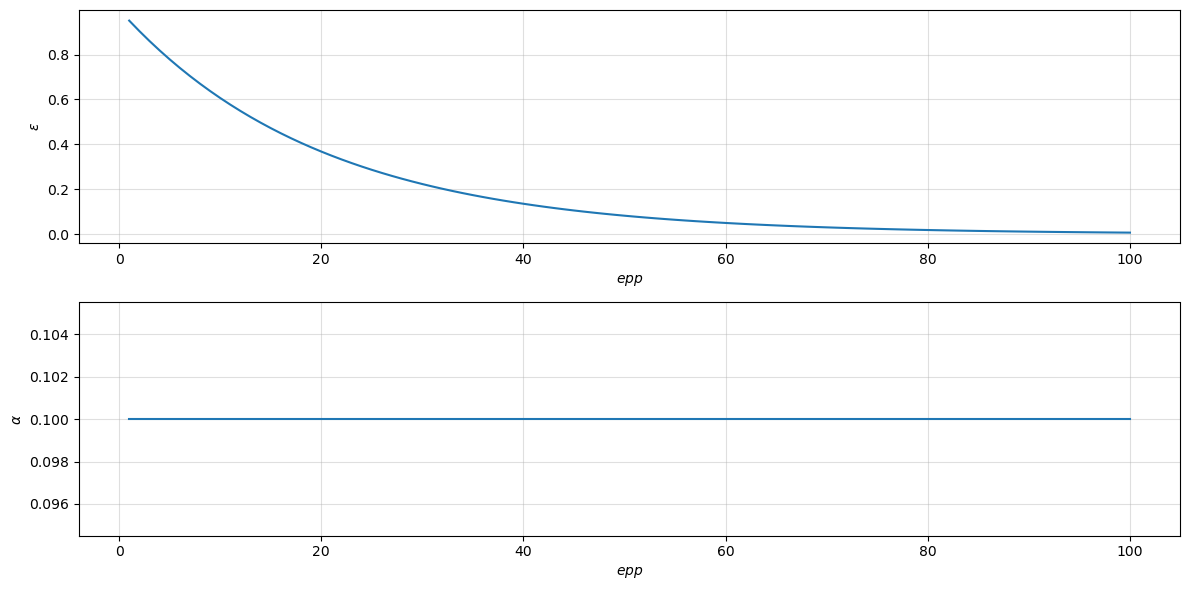

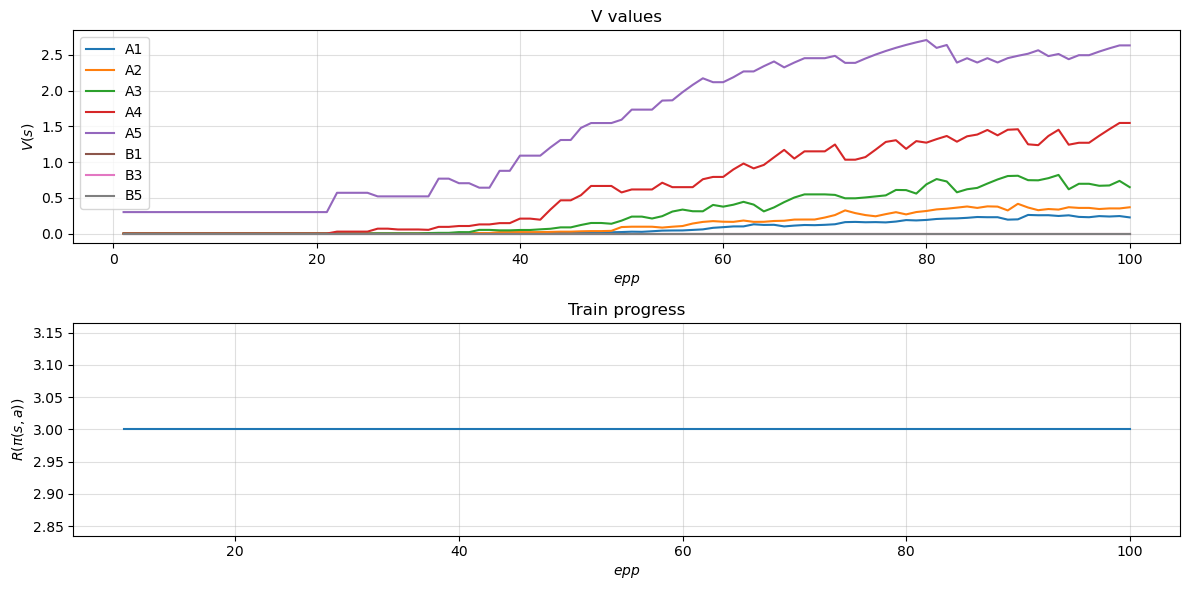

In [9]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 100
temp = np.arange(epochs) + 1
epsilon = np.exp(-temp/20)
alpha = 0.1
q_learning = Q_learning(Simulator(grid, action_set), gamma, alpha, epsilon, epochs)
q_learning.fit(True)
del q_learning

**Komentar:** sa prethodno prikazanih grafika moze se uociti da je konstanta ucenja $\alpha = 0.1$ premala i da Q(s, a) vrednosti jako sporo konvrgiraju iako je politika koja je formirana u poroseku davala savrsenu nagradu.

#### Scenario 2
* $\gamma = 0.9$
* $\alpha = 0.4$

Epoch:  100
          up      down      left     right       max
A1  0.716664 -0.686813 -0.089588  0.299740  0.716664
A2  0.627957  0.630391  0.649066  1.285594  1.285594
A3  1.728478 -0.382007  0.143214  0.540720  1.728478
A4  1.316949  1.633782  0.596980  2.552249  2.552249
A5  1.549878  2.921097  1.308019  2.054060  2.921097
B1  0.000000  0.000000  0.000000  0.000000  0.000000
B3  0.000000  0.000000  0.000000  0.000000  0.000000
B5  0.000000  0.000000  0.000000  0.000000  0.000000
   action
A1     up
A2  right
A3     up
A4  right
A5   down
B1   left
B3  right
B5   left


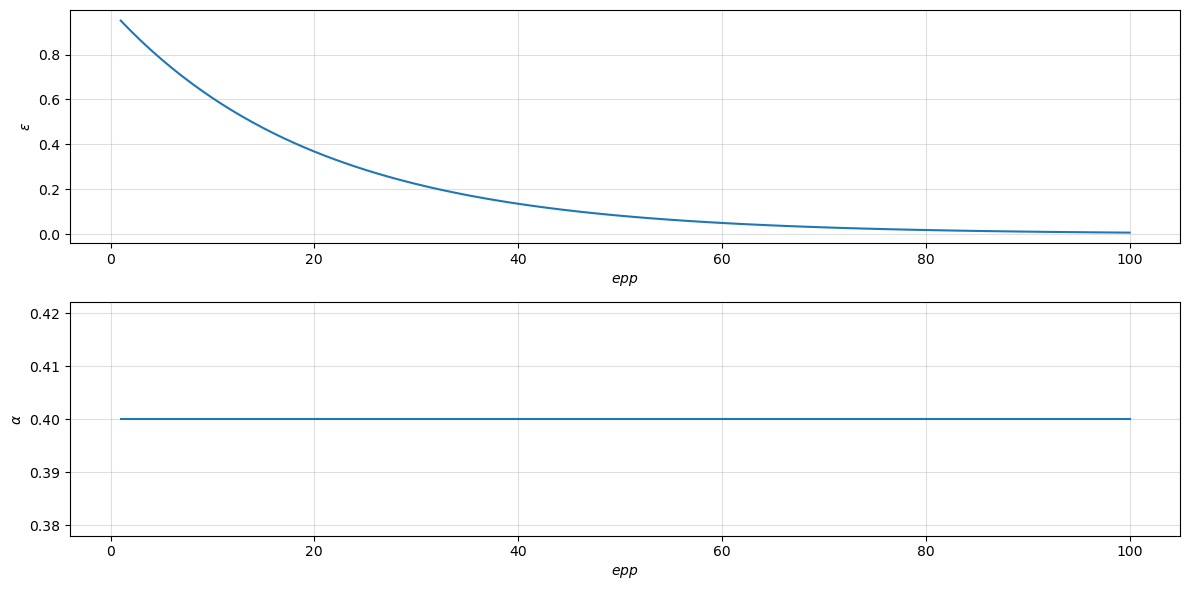

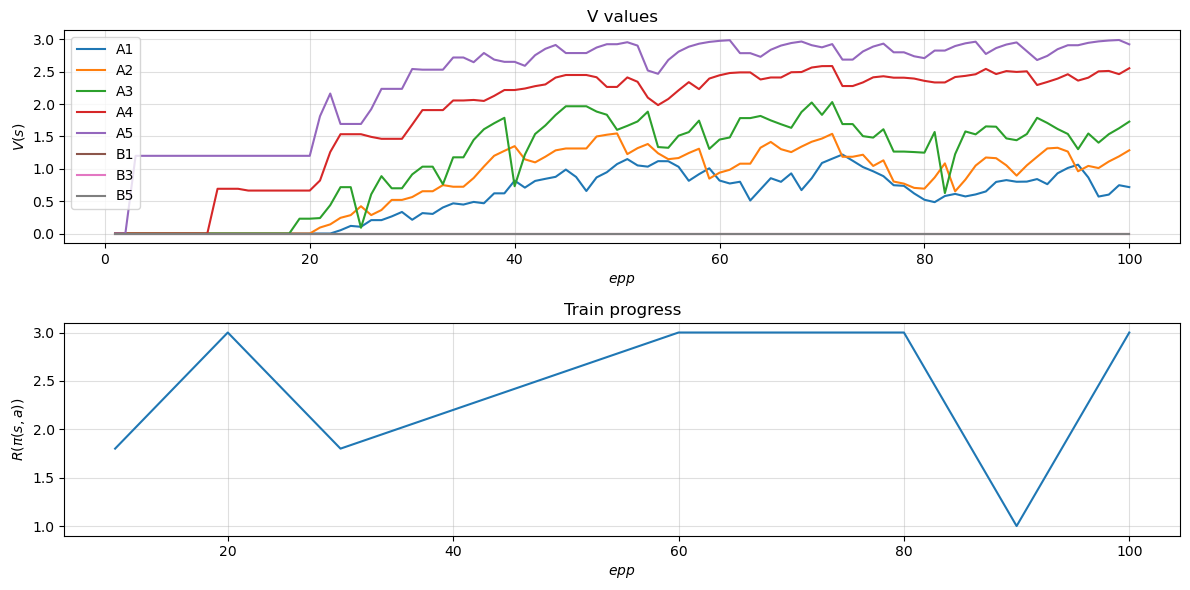

In [10]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 100
temp = np.arange(epochs) + 1
epsilon = np.exp(-temp/20)
alpha = 0.4
q_learning = Q_learning(Simulator(grid, action_set), gamma, alpha, epsilon, epochs)
q_learning.fit(True)
del q_learning

**Komentar:** sa prethodno prikazanih grafika moze se uociti da je konstanta ucenja $\alpha = 0.4$ bolja i da Q(s, a) vrednosti brze konvrgiraju i daju optimalniju politiku.

#### Scenario 3
* $\gamma = 0.9$
* $\alpha_e = \frac{ln(e+1)}{e+1}$

Epoch:  100
          up      down      left     right       max
A1  0.346845 -0.677237 -0.241210 -0.012142  0.346845
A2  0.057579  0.065778  0.043226  0.558819  0.558819
A3  0.695858 -0.605234  0.052624 -0.120015  0.695858
A4  0.295405  1.323908  0.200256  0.594031  1.323908
A5  0.272559  2.498958  0.348975  0.150283  2.498958
B1  0.000000  0.000000  0.000000  0.000000  0.000000
B3  0.000000  0.000000  0.000000  0.000000  0.000000
B5  0.000000  0.000000  0.000000  0.000000  0.000000
   action
A1     up
A2  right
A3     up
A4   down
A5   down
B1     up
B3  right
B5   left


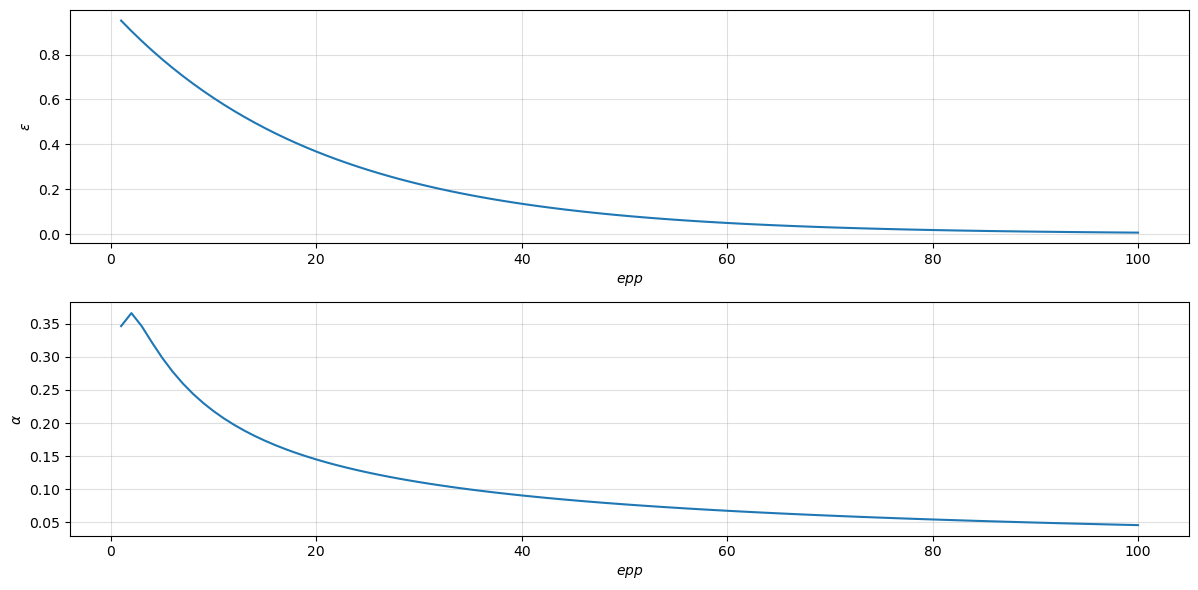

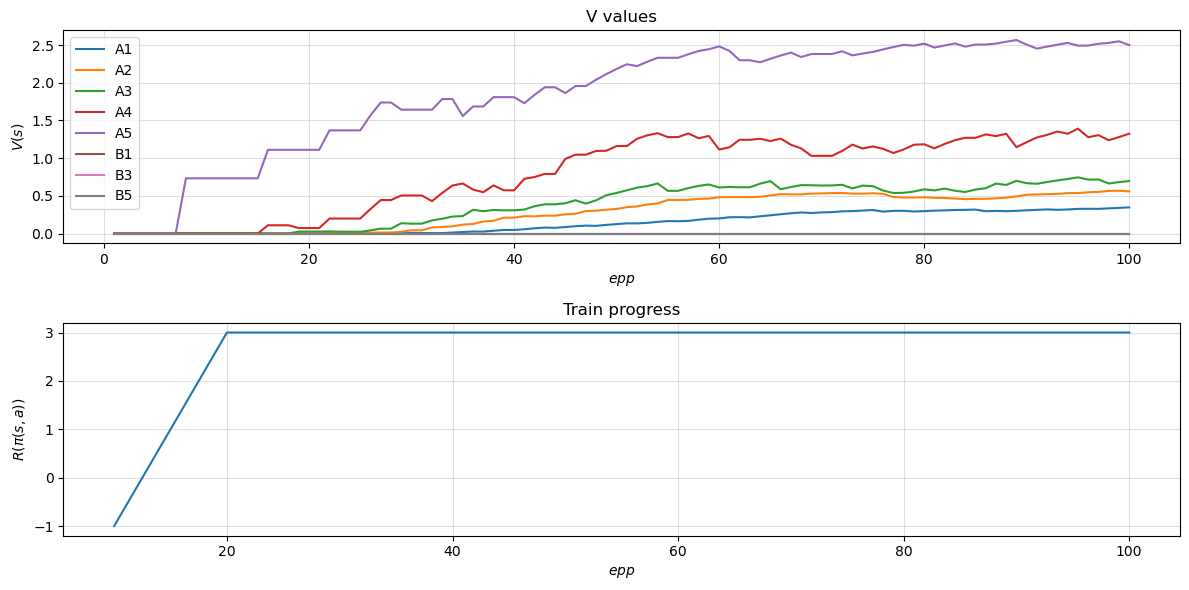

In [11]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 100
temp = np.arange(epochs) + 1
epsilon = np.exp(-temp/20)
alpha = np.log(temp+1)/(temp+1)
q_learning = Q_learning(Simulator(grid, action_set), gamma, alpha, epsilon, epochs)
q_learning.fit(True)
del q_learning

**Komentar:** Moze se uociti da teorijska strategija za konstantu ucenja daje slicniju konvergenciju kao u prvom scenariju konvergencija je spora i potrebno ju je malo povecati. 

#### Scenario 4
* $\gamma = 0.9$
* $\alpha_e = \frac{ln(e+1)}{e+1} + 0.1$

Epoch:  100
          up      down      left     right       max
A1  0.902061 -0.947019  0.040147  0.153855  0.902061
A2  0.176245  0.196565  0.253448  1.269866  1.269866
A3  1.538161  0.031216  0.042426  0.423386  1.538161
A4  0.941619  0.199199  0.685866  2.346771  2.346771
A5  1.762657  2.699660  1.626212  1.820057  2.699660
B1  0.000000  0.000000  0.000000  0.000000  0.000000
B3  0.000000  0.000000  0.000000  0.000000  0.000000
B5  0.000000  0.000000  0.000000  0.000000  0.000000
   action
A1     up
A2  right
A3     up
A4  right
A5   down
B1   down
B3     up
B5   down


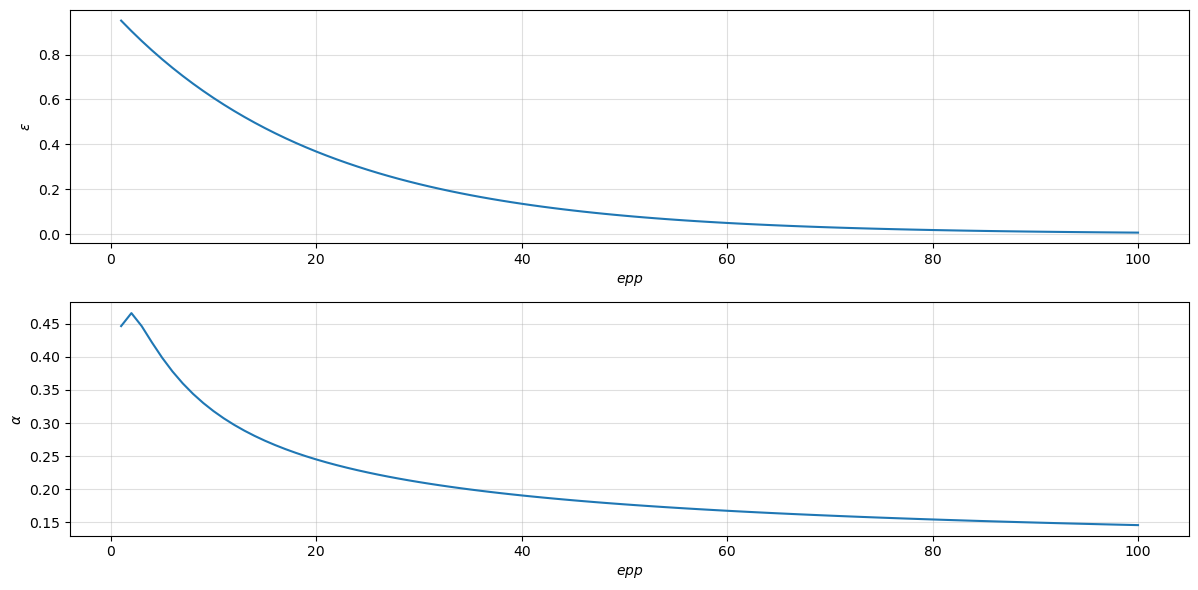

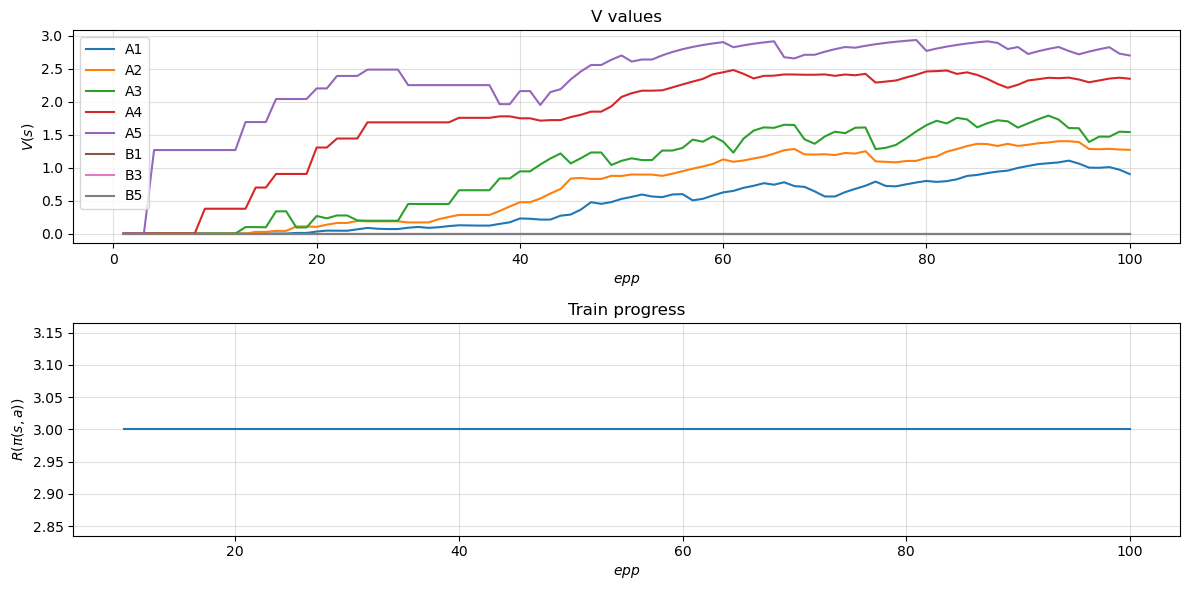

In [12]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 100
temp = np.arange(epochs) + 1
epsilon = np.exp(-temp/20)
alpha = np.log(temp+1)/(temp+1) + 0.1
q_learning = Q_learning(Simulator(grid, action_set), gamma, alpha, epsilon, epochs)
q_learning.fit(True)
del q_learning

**Komentar:** Nakon povecanja moze se uociti da se konvregencija ubrzava i daje dosta dobre rezulate.

#### Scenario 5
* $\gamma = 0.999$
* $\alpha_e = \frac{ln(e+1)}{e+1} + 0.1$

Epoch:  100
          up      down      left     right       max
A1  2.574101 -0.708128  1.389187  0.682359  2.574101
A2  2.622582  1.347857  0.810230  0.956938  2.622582
A3  2.703881  0.111766  1.021210  0.565940  2.703881
A4  2.831991  0.522697  0.782028  0.743201  2.831991
A5  0.269906  2.983217  0.299781  0.269906  2.983217
B1  0.000000  0.000000  0.000000  0.000000  0.000000
B3  0.000000  0.000000  0.000000  0.000000  0.000000
B5  0.000000  0.000000  0.000000  0.000000  0.000000
   action
A1     up
A2     up
A3     up
A4     up
A5   down
B1  right
B3     up
B5   left


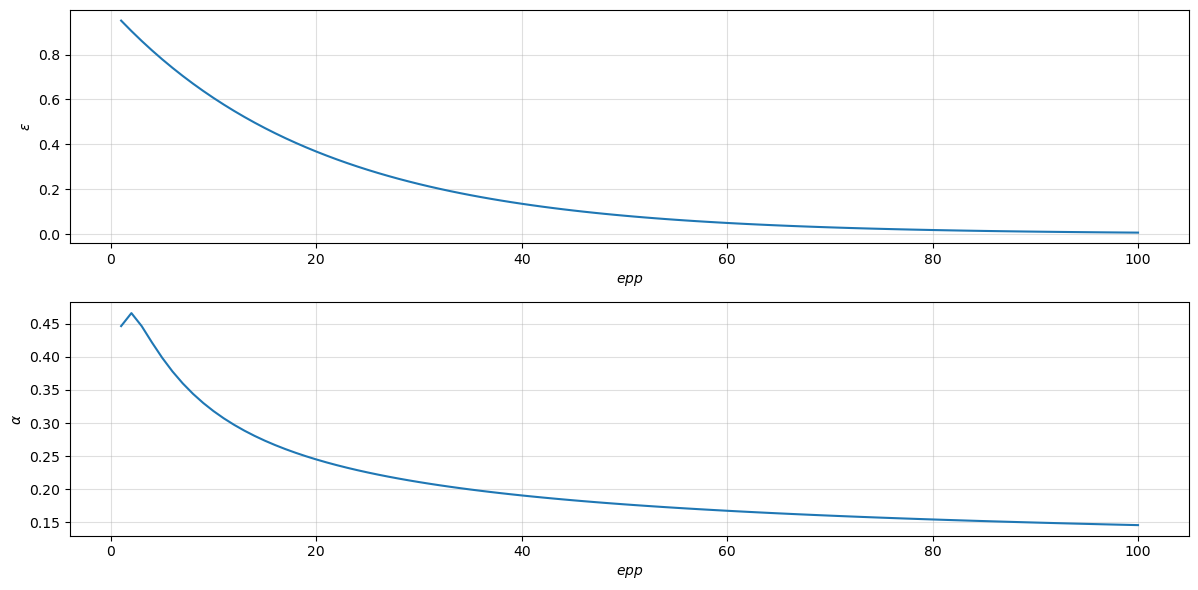

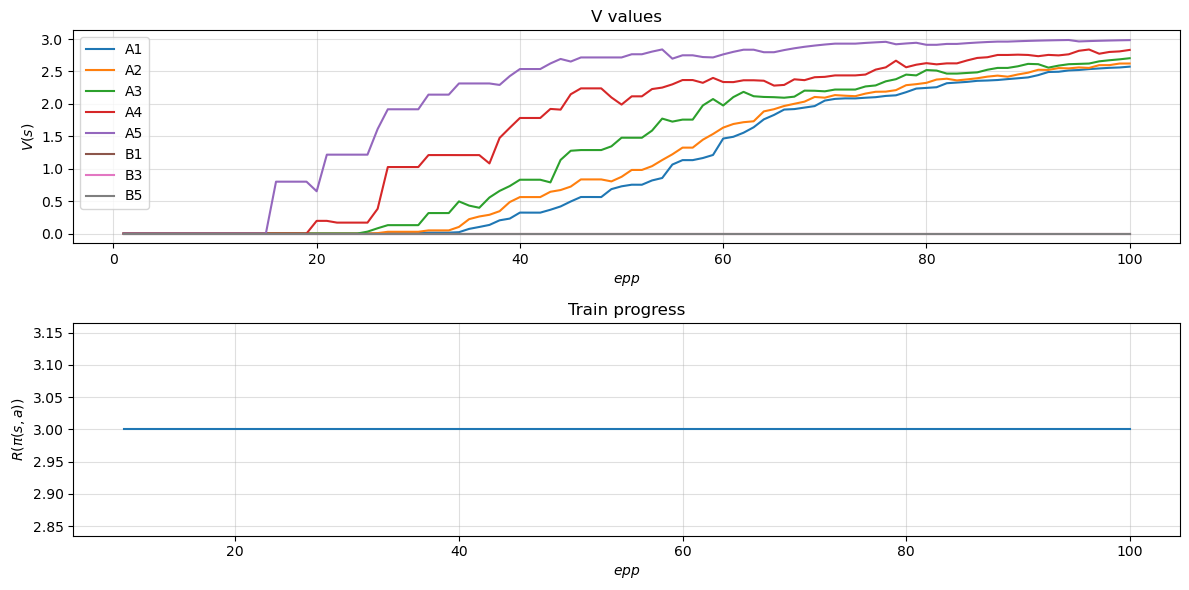

In [13]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.999
epochs = 100
temp = np.arange(epochs) + 1
epsilon = np.exp(-temp/20)
alpha = np.log(temp+1)/(temp+1) + 0.1
q_learning = Q_learning(Simulator(grid, action_set), gamma, alpha, epsilon, epochs)
q_learning.fit(True)
del q_learning

**Komentar:** Nakon promene stepena umanjenja buducih nagrada moze se uociti promena u optimalnoj politici gde je algotitam konvergirao ka akcijama koje su sigurnije iako ne garantuju najbrzu putanju, jer je stepen umanjenja buducih nagrada skoro 1, pa akcije koje naizgled ne deluju optimalno u smislu brzine dolaska u terminalno stanje sa najvecom nagradom postaju optimalne, takodje sve V(s) vrednosti su konvergirale ka vrednosti +3. 

## REINFORCE
Pratite kako ucenje napreduje tako sto cete povremeno “zamrzavati” do tada naucenu politiku, ponavljati 10 epizoda interakcije agenta sa okruzenjem, i racunati prosecnu ukupnu nagradu koju agent osvaja tokom jedne epizode.
Graficki prikazite kako se tokom ucenja menjaju
* pomenuta nagrada u 10 uzastopnih epizoda,
* vrednosti parametara politike u neterminalnim stanjima.
Eksperimentisite sa stopama ucenja, kao kod Q-ucenja. Usvojite $\gamma = 0.9$.

In [14]:
class Reinforce:
    def __init__(self, simulator: Simulator, gamma, alpha, epochs):
        self.__simulator = simulator
        self.__gamma = gamma
        
        self.__epochs = epochs
        self.__alpha = alpha
        self.__theta_values_table = self.__make_theta_values_table()
        self.__policy_table = self.__make_policy_table()
        return
    
    def __label_states(self):
        grid = self.__simulator.get_grid()
        heigth, width = grid.shape
        self.__states = []
        for i in range(heigth):
            for j in range(width):
                if grid[i, j] != 'x':
                    self.__states.append(string.ascii_uppercase[i] + str(j+1))
        return 
    
    def __make_theta_values_table(self):
        self.__label_states()
        data = []
        for i in range(len(self.__states)):
            theta_up, theta_down, theta_left, theta_right = np.random.randn(4)
            # theta_up, theta_down, theta_left, theta_right = np.ones(shape=(4,))
            data.append({"theta_up": theta_up, "theta_down": theta_down, "theta_left": theta_left, "theta_right": theta_right})    
        return pd.DataFrame(data, index=self.__states)
    
    def __make_policy_table(self):
        action_set = list(self.__simulator.get_action_set().keys())
        data = []
        for i in range(len(self.__states)):
            p_up, p_down, p_left, p_right = self.__softmax_parametrization(self.__theta_values_table.loc[self.__states[i]].to_numpy())
            data.append({"p_up": p_up, "p_down": p_down, "p_left": p_left, "p_right": p_right})  
        return pd.DataFrame(data, index=self.__states)
    
    def __softmax_parametrization(self, theta):
        p = np.exp(theta)/sum(np.exp(theta))
        return p
    
    def fit(self, verbose):
        action_set = list(self.__simulator.get_action_set().keys())
        epp = 0
        
        state = self.__simulator.get_start_state()
        one_epp = []
        self.__v_values = np.empty(shape=(self.__epochs, len(self.__states)))
        gamma_coef = self.__gamma
        mean_values = []
        while epp < self.__epochs:
            action = np.random.choice(action_set, p = self.__policy_table.loc[state].to_numpy())
            new_state, value, finished = self.__simulator.increment_state(action)
            one_epp.append({"state": state, "action": action, "value": float(value)})
            
            if finished:
                # Q(s, a) ~ Vt ~ sum gamma^(tau-t) * r(tau)
                for i in range(2, len(one_epp)+1):
                    one_epp[-i]["value"] = gamma_coef * one_epp[-1]["value"]
                    gamma_coef = gamma_coef * self.__gamma
                
                # updating theta
                for i in range(len(one_epp)):
                    s = one_epp[i]['state']
                    a = one_epp[i]['action']
                    pi = self.__policy_table.loc[s, "p_" + a]
                    score = 1 - pi
                    if type(self.__alpha) == float:
                        alpha = self.__alpha
                    else:
                        alpha = self.__alpha[epp]
                    self.__theta_values_table.loc[s, "theta_" + a] += alpha*score*one_epp[i]["value"]
                    
                    # updating policy table
                    prob = self.__softmax_parametrization(self.__theta_values_table.loc[s].to_numpy())
                    prob[np.isnan(prob)] = 1
                    self.__policy_table.loc[s] = prob
                
                if verbose:                    
                    if epp % 10 == 0:
                        no = 10
                        values = np.empty(shape=(no))
                        for i in range(no):
                            values[i] = self.interact()
                        mean_values.append(np.mean(values))
                
                # resetting simulator
                epp += 1
                state = self.__simulator.get_start_state()
                self.__simulator.reset()
                one_epp = []
                gamma_coef = self.__gamma
                
                IPython.display.clear_output(wait=True)
                print("Epp: ", epp)
                print(self.__theta_values_table)
                print(self.__policy_table)
                
            else:
                state = new_state
        
        if verbose:
            plt.figure(figsize=FIGSIZE, dpi=DPI)
            plt.plot((np.arange(len(mean_values))+1)*10, mean_values)
            plt.grid(alpha=ALPHA)
            plt.xlabel("$ epp $")
            plt.ylabel("$ R(\\pi(s, a)) $")
            plt.title("Train progress")
        return
    
    def interact(self):
        action_set = list(self.__simulator.get_action_set().keys())
        self.__simulator.reset()
        state = self.__simulator.get_start_state()
        finished = False
        while not finished:
            action = np.random.choice(action_set, p = self.__policy_table.loc[state].to_numpy())
            state, value, finished = self.__simulator.increment_state(action)
        self.__simulator.reset()
        return value
        

### Rezultati

#### Scenario 1
* $\gamma = 0.9$
* $\alpha = 0.1$

Epp:  300
    theta_up  theta_down  theta_left  theta_right
A1 -0.858588   -4.900576   -3.834772    -1.866185
A2  2.402324   -1.291974   -0.442533     2.307861
A3  0.290556   -1.911814   -1.683235     2.373868
A4  9.584780    4.710461    0.384350     7.471340
A5 -0.856094    4.911955    1.225261     0.999251
B1 -2.080696    0.410587    2.336361     1.657594
B3 -1.188859    0.207182    0.657794    -0.948778
B5 -0.157071   -1.946395    1.875258    -1.063677
        p_up    p_down    p_left   p_right
A1  0.697523  0.012250  0.035565  0.254662
A2  0.501789  0.012477  0.029175  0.456559
A3  0.107753  0.011911  0.014970  0.865366
A4  0.886083  0.006770  0.000089  0.107058
A5  0.002982  0.954047  0.023903  0.019068
B1  0.007249  0.087541  0.600574  0.304636
B3  0.079057  0.319325  0.501108  0.100509
B5  0.108663  0.018155  0.829295  0.043888


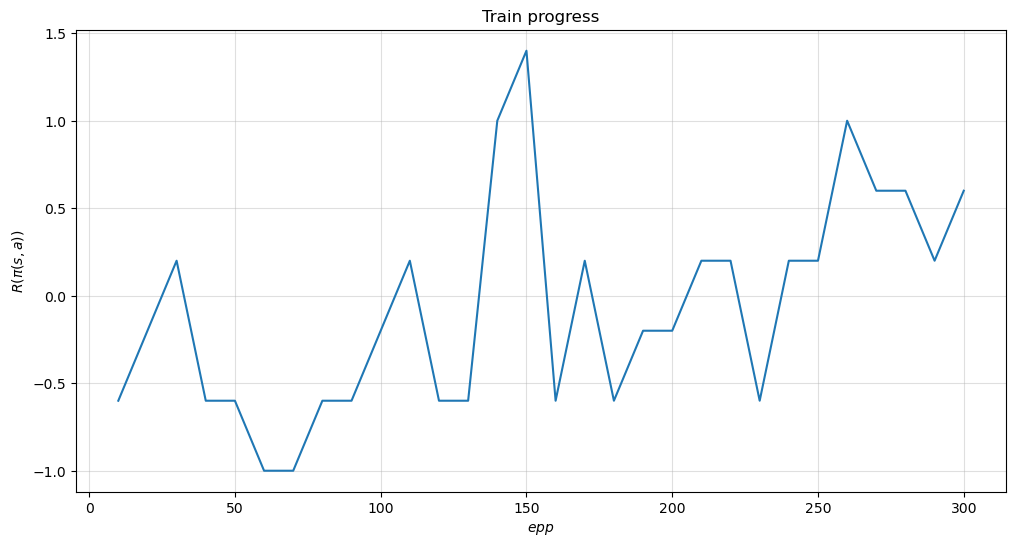

In [15]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 300
temp = np.arange(epochs) + 1
epsilon = np.exp(-temp/100)
alpha = 0.1
reinforce = Reinforce(Simulator(grid, action_set), gamma, alpha, epochs)
reinforce.fit(True)
del reinforce

**Komentar:** Stopa ucenja $\alpha = 0.1$ je premala konvergencija je suvise spora.

#### Scenario 2
* $\gamma = 0.9$
* $\alpha = 0.5$

Epp:  300
     theta_up  theta_down  theta_left  theta_right
A1   7.656622   -1.444623   -2.514296    10.280015
A2   1.909553   19.821259    0.069609    23.123582
A3   3.249156   -0.868926   -1.707571     8.516969
A4  12.527843   -1.099090    0.082851    18.242578
A5   0.530678    9.816860    3.831015     4.207598
B1   0.494696   -0.512474    1.131076     1.524808
B3  -1.059855   -0.279823   -0.963865    -0.087997
B5   1.783003   -0.520666   -0.585343    -0.105339
            p_up        p_down        p_left   p_right
A1  6.764727e-02  7.544493e-06  2.588672e-06  0.932343
A2  5.904323e-10  3.549159e-02  9.377627e-11  0.964508
A3  5.127818e-03  8.345887e-05  3.607893e-05  0.994753
A4  3.286189e-03  3.968173e-09  1.293902e-08  0.996714
A5  9.211865e-05  9.937685e-01  2.498424e-03  0.003641
B1  1.651185e-01  6.030968e-02  3.120125e-01  0.462559
B3  1.444015e-01  3.150177e-01  1.589496e-01  0.381631
B5  7.435775e-01  7.427724e-02  6.962522e-02  0.112520


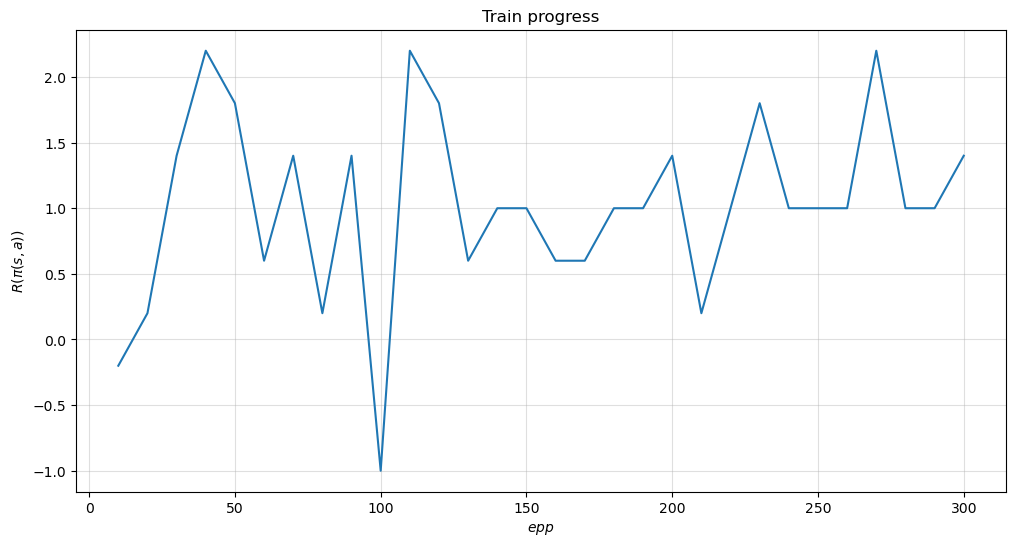

In [16]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 300
temp = np.arange(epochs) + 1
alpha = 0.5
reinforce = Reinforce(Simulator(grid, action_set), gamma, alpha, epochs)
reinforce.fit(True)
del reinforce

**Komentar:** Stopa ucenja $\alpha = 0.4$ je konvergirala brze ali politika u proseku daje nagradu od 1.5, iz naucenih parametara politike se moze uociti da je politika konvergirala ka politici koja nije uvek najsigurnija. 

#### Scenario 3
* $\gamma = 0.9$
* $\alpha_e = \frac{ln(e+1)}{e+1} + 0.3$

Epp:  300
     theta_up  theta_down  theta_left  theta_right
A1   0.636479  -11.769550  -10.070585    -4.067635
A2   1.388665   -1.334911   -2.790588     5.599537
A3  30.532640   -1.359315   -1.631283    32.821777
A4   5.947442   -1.857455   -1.280405    11.016317
A5   1.270771   17.072340   12.055035    -2.167440
B1  -1.017482   -0.563395    1.145918     1.335366
B3   1.267375   -0.766393    0.416680     1.355204
B5   0.071594   -1.156378   -0.635945    -0.401531
            p_up        p_down        p_left       p_right
A1  9.909974e-01  4.056978e-06  2.218471e-05  8.976388e-03
A2  1.459935e-02  9.582954e-04  2.235151e-04  9.842188e-01
A3  9.202662e-02  1.298415e-15  9.892350e-16  9.079734e-01
A4  6.250135e-03  2.548390e-06  4.538112e-06  9.937428e-01
A5  1.363325e-07  9.934211e-01  6.578781e-03  4.379286e-09
B1  4.589074e-02  7.226574e-02  3.992804e-01  4.825631e-01
B3  3.773925e-01  4.937863e-02  1.611911e-01  4.120378e-01
B5  4.151454e-01  1.215903e-01  2.046068e-01  2.586574e-01


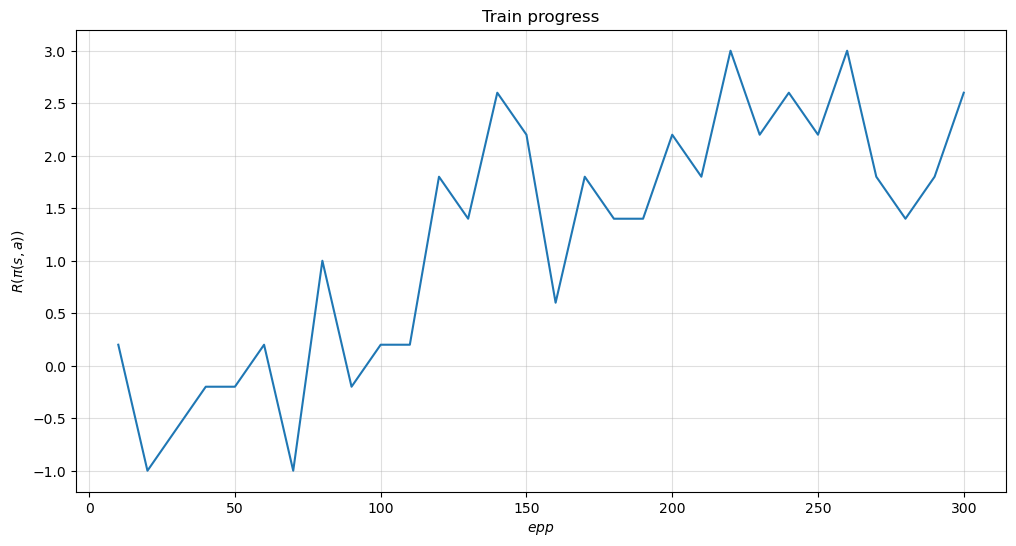

In [25]:
action_set = {"up": (-1, 0), "down": (1, 0), "left": (0, -1),
                "right": (0, 1)}
grid = make_grid()
gamma = 0.9
epochs = 300
temp = np.arange(epochs) + 1
alpha = np.log(temp+1)/(temp+1) + 0.3
reinforce = Reinforce(Simulator(grid, action_set), gamma, alpha, epochs)
reinforce.fit(True)
del reinforce

**Komentar:** Teorijska strategija za stopu ucenja je daje najbrzu konvergenciju, ka optimalnoj politici.